# Поиск точек роста в сервисе доставки еды: анализ поведения клиентов и сегментация ресторанов-партнеров

Автор: Гребенкина Наталья

Дата: 09.02.2026

---

## Введение

### О продукте
«Все.из.кафе» — сервис доставки еды из ресторанов. Пользователи могут оформлять заказы через мобильное приложение и десктоп-версию.
Бизнес-модель: маркетплейс — сервис получает комиссию с каждого заказа ресторана-партнера.

### Бизнес-контекст и задачи
Продукт столкнулся с типичной для рынка доставки проблемой: рекламный трафик стабилен, установки приложения растут, но количество заказов снижается. 
Маркетинг и продакшн выдвинули гипотезы, но требуют аналитического подтверждения.

**Ключевые вопросы бизнеса:**
1. Где именно «отваливаются» пользователи? Какие этапы воронки проблемные?
2. Почему пользователи не возвращаются? Как сегментировать клиентов по лояльности?
3. Все ли рестораны-партнеры работают одинаково эффективно? Кто требует особых условий?

### Цель исследования
Найти инсайты для:
- повышения конверсии из нового пользователя в заказ;
- увеличения удержания и частоты повторных покупок;
- разработки персонализированных стратегий работы с ресторанами.

### План анализа
1. **Анализ пользовательского пути** — построение воронок, сравнение мобильной и десктопной версий.
2. **RFM-сегментация** — выделение групп клиентов по давности, частоте и сумме покупок.
3. **Кластеризация ресторанов** — сегментация партнеров для персонализации условий.
4. **Итоговые рекомендации** — приоритезированный список действий.

### Данные для анализа

Анализ выполняется на основе логов сервиса за период с 1 мая по 2 июля 2021 года.  
Данные представлены одним датасетом, содержащим все ключевые события пользовательского пути, а также информацию о заказах и ресторанах.

| Поле | Описание |
|------|----------|
| `visitor_uuid` | Идентификатор посетителя (присваивается системой любому новому пользователю) |
| `user_id` | Идентификатор зарегистрированного пользователя |
| `device_type` | Тип устройства: `Mobile` или `Desktop` |
| `city_id` | Идентификатор города |
| `source` | Рекламный источник привлечения |
| `first_date` | Дата первого посещения продукта |
| `visit_id` | Уникальный идентификатор сессии |
| `event` | Аналитическое событие (авторизация, просмотр, заказ и т.д.) |
| `datetime` | Дата и время события |
| `rest_id` | Идентификатор ресторана |
| `object_id` | Идентификатор блюда |
| `order_id` | Идентификатор заказа |
| `revenue` | Выручка от заказа, руб. |
| `delivery` | Стоимость доставки, руб. |
| `commission` | Комиссия сервиса с выручки ресторана, % |


---
## Содержание

3. [Загрузка и предобработка данных](#zagruzka)

4. [Анализ пользовательского пути](#put)

5. [RFM-сегментация: анализ лояльности клиентов](#rfm)

6. [Кластеризация ресторанов](#restorany)

7. [Итоговые выводы и рекомендации](#vyvody)

---
<a id="zagruzka"></a>
## Загрузка и предобработка данных

Задача этапа оценить качество исходных данных и подготовить их к анализу:
- загрузка и первичное знакомство
- проверка целостности и устранение дубликатов
- оптимизация типов
- фиксация ключевых параметров датасета

In [1]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
# Импортируем датасет
df = pd.read_csv('https://code.s3.yandex.net/datasets/insides_data.csv', parse_dates = ['first_date', 'datetime'])

display(df.head())
print(df.info())

,visitor_uuid,user_id,device_type,city_id,source,first_date,visit_id,event,datetime,rest_id,object_id,order_id,revenue,delivery,commission
0,01b5da38-3022-48ff-87c0-5519247fef1b,567317.0,Desktop,6,Source_B,2021-05-01,171481813,authorization,2021-05-01 16:07:53,NaN,NaN,NaN,NaN,NaN,NaN
1,01b5da38-3022-48ff-87c0-5519247fef1b,567317.0,Desktop,6,Source_B,2021-05-01,171481813,reg_page,2021-05-01 16:09:16,NaN,NaN,NaN,NaN,NaN,NaN
2,01b5da38-3022-48ff-87c0-5519247fef1b,567317.0,Desktop,6,Source_B,2021-05-01,171481813,confirm_phone,2021-05-01 16:09:19,NaN,NaN,NaN,NaN,NaN,NaN
3,01b5da38-3022-48ff-87c0-5519247fef1b,567317.0,Desktop,6,Source_B,2021-05-01,171481813,login,2021-05-01 16:09:23,NaN,NaN,NaN,NaN,NaN,NaN
4,01b5da38-3022-48ff-87c0-5519247fef1b,567317.0,Desktop,6,Source_B,2021-05-01,171481813,main_page,2021-05-01 16:09:34,2c6095730b514c189ee41c65f03febc3,NaN,NaN,NaN,NaN,NaN


<class 'pandas.DataFrame'>
RangeIndex: 205510 entries, 0 to 205509
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   visitor_uuid  205510 non-null  str           
 1   user_id       205510 non-null  float64       
 2   device_type   205510 non-null  str           
 3   city_id       205510 non-null  int64         
 4   source        205510 non-null  str           
 5   first_date    205510 non-null  datetime64[us]
 6   visit_id      205510 non-null  int64         
 7   event         205510 non-null  str           
 8   datetime      205510 non-null  datetime64[us]
 9   rest_id       166915 non-null  str           
 10  object_id     21308 non-null   float64       
 11  order_id      7008 non-null    float64       
 12  revenue       7008 non-null    float64       
 13  delivery      7008 non-null    float64       
 14  commission    21308 non-null   float64       
dtypes: datetime64[us](2), float6

Колонки `visitor_uuid` и `user_id` не имеют пустых значений. Однако в документации отмечено, что идентификатор зарегистрированного пользователя присваивается посетителю после создания учетной записи. Проверим количество уникальных значений `visitor_uuid` и `user_id`.

In [3]:
# Определяем количество уникальных записей полей 'visitor_uuid' и 'user_id'
print(f"Уникальных записей в поле 'visitor_uuid': {df['visitor_uuid'].nunique()}")
print(f"Уникальных записей в поле 'user_id': {df['user_id'].nunique()}")

Уникальных записей в поле 'visitor_uuid': 8891
Уникальных записей в поле 'user_id': 8473


In [4]:
# Строим распределение user_id по количеству ассоциированных visitor_uuid
distribution = (df.groupby('user_id', as_index=False)['visitor_uuid']
                .nunique()
                .groupby('visitor_uuid', as_index=False)['user_id']
                .count()
                .rename(columns={'visitor_uuid': 'cnt_visitor_uuid_per_user', 'user_id': 'cnt_unique_users'}))

display(distribution)

,cnt_visitor_uuid_per_user,cnt_unique_users
0,1,7995
1,2,434
2,3,34
3,4,4
4,5,3
5,7,1
6,9,2


Идентификатор `visitor_uuid` не является уникальным для пользователей. Для дальнейшего анализа в качестве идентификатора пользователя будем использовать `user_id`, поскольку он уникален и заполнен для всех записей датасета.

In [5]:
# Проверяем возможность преобразования поля user_id к типу integer
is_all_integer = (df['user_id'] % 1 == 0).all()
print(f"Все значения целые: {is_all_integer}")

Все значения целые: True


In [6]:
# Преобразуем тип данных для поля 'user_id'
df['user_id'] = df['user_id'].astype('int')
print(f"Тип данных поля 'user_id': {df['user_id'].dtypes}")

Тип данных поля 'user_id': int64


In [7]:
# Оцениваем количество уникальных записей для 'device_type', 'city_id', 'source'
for col in ['device_type', 'city_id', 'source', 'event']:
    print(f"Уникальных значений в поле '{col}': {df[col].nunique()}")

Уникальных значений в поле 'device_type': 2
Уникальных значений в поле 'city_id': 6
Уникальных значений в поле 'source': 4
Уникальных значений в поле 'event': 8


Низкая кардинальность полей `device_type` (2 значения), `city_id` (6), `source` (4) и `event`(8) позволяет преобразовать их в категориальный тип данных для экономии памяти и ускорения группировок.

In [8]:
# Преобразуем тип данных для полей 'device_type', 'city_id', 'source'
df[['device_type', 'city_id', 'source', 'event']] = df[['device_type', 'city_id', 'source', 'event']].astype('category')
print(df.info())

<class 'pandas.DataFrame'>
RangeIndex: 205510 entries, 0 to 205509
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   visitor_uuid  205510 non-null  str           
 1   user_id       205510 non-null  int64         
 2   device_type   205510 non-null  category      
 3   city_id       205510 non-null  category      
 4   source        205510 non-null  category      
 5   first_date    205510 non-null  datetime64[us]
 6   visit_id      205510 non-null  int64         
 7   event         205510 non-null  category      
 8   datetime      205510 non-null  datetime64[us]
 9   rest_id       166915 non-null  str           
 10  object_id     21308 non-null   float64       
 11  order_id      7008 non-null    float64       
 12  revenue       7008 non-null    float64       
 13  delivery      7008 non-null    float64       
 14  commission    21308 non-null   float64       
dtypes: category(4), datetime64[u

In [9]:
# Оптимизируем разрядность типов данных числовых полей
cols = df.columns.tolist()

for col in cols:
    if df[col].dtypes == 'int64':
        df[col] = pd.to_numeric(df[col], downcast='integer')
    elif df[col].dtypes == 'float64':
        df[col] = pd.to_numeric(df[col], downcast='float')

print(df.info())

<class 'pandas.DataFrame'>
RangeIndex: 205510 entries, 0 to 205509
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   visitor_uuid  205510 non-null  str           
 1   user_id       205510 non-null  int32         
 2   device_type   205510 non-null  category      
 3   city_id       205510 non-null  category      
 4   source        205510 non-null  category      
 5   first_date    205510 non-null  datetime64[us]
 6   visit_id      205510 non-null  int32         
 7   event         205510 non-null  category      
 8   datetime      205510 non-null  datetime64[us]
 9   rest_id       166915 non-null  str           
 10  object_id     21308 non-null   float32       
 11  order_id      7008 non-null    float32       
 12  revenue       7008 non-null    float64       
 13  delivery      7008 non-null    float32       
 14  commission    21308 non-null   float32       
dtypes: category(4), datetime64[u

**Промежуточный итог**

В ходе предобработки данных были выполнены следующие оптимизации типов данных:
- Преобразование числовых полей: понижение разрядности, изменение типа данных для поля user_id.
- Преобразование категориальных полей.

Результат оптимизации:
- Исходный размер в памяти: 23,5+ MB
- После оптимизации: 12,5+ MB
- Экономия памяти: ≈ 47% (уменьшение почти в 2 раза)

In [10]:
# Проверяем наличие полных дубликатов
duplicates = df.duplicated().sum()
print(f"Полных дубликатов строк: {duplicates}")

# Проверяем наличие частичных дубликатов по пользователям и событиям
columns = ['user_id', 'datetime', 'event']
partial_duplicates = df.duplicated(subset=columns).sum()
print(f"Частичных дубликатов: {partial_duplicates}")

# Проверяем наличие частичных дубликатов внутри сессий
session_dups = df.duplicated(subset=['visit_id', 'event', 'datetime']).sum()
print(f"Повторяющихся событий в сессиях: {session_dups}")

Полных дубликатов строк: 0
Частичных дубликатов: 7
Повторяющихся событий в сессиях: 0


In [11]:
# Выводим частичные дубликаты
columns = ['user_id', 'datetime', 'event']
duplicates = df[df.duplicated(subset=columns, keep=False)]

print(f"События: {duplicates['event'].unique().astype(str)}")
print(f"Девайсы: {duplicates['device_type'].unique().astype(str)}")
print(f"Города: {duplicates['city_id'].unique().astype(str)}")
print(f"Даты: {sorted(duplicates['datetime'].dt.strftime('%Y-%m-%d').unique())}")
print(f"Пользователи: {duplicates['user_id'].unique()}\n")

display(duplicates.head())

События: <StringArray>
['authorization']
Length: 1, dtype: str
Девайсы: <StringArray>
['Desktop']
Length: 1, dtype: str
Города: <StringArray>
['6']
Length: 1, dtype: str
Даты: ['2021-05-03', '2021-05-04', '2021-05-12', '2021-05-13', '2021-05-18', '2021-05-26', '2021-06-25']
Пользователи: [570334 570841 580940 146532 563661 594482 596594]



,visitor_uuid,user_id,device_type,city_id,source,first_date,visit_id,event,datetime,rest_id,object_id,order_id,revenue,delivery,commission
6053,011d6385-8508-44f6-a208-693439a959d2,570334,Desktop,6,Source_C,2021-05-01,172092821,authorization,2021-05-03 18:18:38,NaN,NaN,NaN,NaN,NaN,NaN
6054,011d6385-8508-44f6-a208-693439a959d2,570334,Desktop,6,Source_C,2021-05-01,172092822,authorization,2021-05-03 18:18:38,NaN,NaN,NaN,NaN,NaN,NaN
14373,f15a5b75-db5b-4329-a82d-31332bb4b62b,570841,Desktop,6,organic,2021-05-03,172287156,authorization,2021-05-04 11:47:25,NaN,NaN,NaN,NaN,NaN,NaN
14374,f15a5b75-db5b-4329-a82d-31332bb4b62b,570841,Desktop,6,organic,2021-05-03,172287157,authorization,2021-05-04 11:47:25,NaN,NaN,NaN,NaN,NaN,NaN
33611,34368fa2-ecc3-4285-8ba5-2cede61d9b2e,580940,Desktop,6,Source_B,2021-05-11,174457841,authorization,2021-05-12 13:06:43,NaN,NaN,NaN,NaN,NaN,NaN


Были обнаружены частичные дубликаты по комбинации полей user_id, datetime и event. Все дубликаты имеют следующие общие характеристики:
- Тип события: Все дублирующиеся записи относятся к событию 'authorization' - авторизации пользователей.
- Платформа: Все случаи дублирования произошли только в десктопной версии приложения (device_type = 'Desktop').
- География: Все дубликаты зафиксированы в городе с ID 6.
- Затронутые пользователи: Всего 7 уникальных пользователей подверглись дублированию записей.
- Временной период: Дублирование происходило в течение двух месяцев:
    - Первые случаи: 3-4 мая 2021 г.
    - Последние случаи: 25 июня 2021 г.
    - Проблема не была единовременной, а проявлялась эпизодически
    
Решение: удалить дублирующиеся записи.

In [12]:
# Удаляем частичные дубликаты
df = df.drop_duplicates(subset=columns, keep='first')
print(f"Количество записей после удаления: {len(df):,}")

Количество записей после удаления: 205,503


In [13]:
# Определяем временной период данных
print(f"Датасет содержит данные за период: c {df['datetime'].min().date()} по {df['datetime'].max().date()}")

Датасет содержит данные за период: c 2021-05-01 по 2021-07-02


In [14]:
# Создаем поле "стаж пользователя в приложении"
df['tenure'] = (pd.to_datetime('2021-07-03') - df['first_date']).dt.days

In [15]:
# Проверяем, что для пользователей отсутствуют записи о заказах ранее даты первой активности
date_anomalies = df[df['datetime'] < df['first_date']]
print(f"Записей о заказах до даты первой активности: {len(date_anomalies)}")

Записей о заказах до даты первой активности: 0


In [16]:
# Проверям, что доставка не превышает стоимость заказа
if (df['delivery'] > df['revenue']).any():
    print(f"Доставка превышает стоимость заказа: {df[df['delivery'] > df['revenue']].count()}")
else:
    print('Стоимость доставки не превышает стоимость заказа')

Стоимость доставки не превышает стоимость заказа


Датасет содержит информацию за период c 2021-05-01 по 2021-07-02.
Проверена логическая целостность данных:
- Не обнаружено случаев, когда событие (включая заказы) происходило бы ранее даты первой активности пользователя (first_date).
- Не обнаружено случаев, когда стоимость доставки превысила стоимость заказа.


In [17]:
# Оцениваем распределение значений выручки, стоимости доставки, комиссии и времени жизни пользователей
desc_custom = df[['revenue', 'delivery', 'commission','tenure']].describe(
    percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).round(2)

display(desc_custom)

,revenue,delivery,commission,tenure
count,7008.00,7008.00,21308.00,205503.00
mean,2522.34,24.54,0.06,35.46
std,2187.80,8.65,0.01,16.69
min,235.20,9.90,0.04,2.00
1%,463.68,10.20,0.04,3.00
5%,658.98,11.40,0.04,9.00
25%,1316.00,17.00,0.05,23.00
50%,1944.60,24.20,0.05,35.00
75%,3150.00,32.10,0.06,50.00
90%,4596.20,36.80,0.08,59.00


1. Выручка (revenue):
    - Средний чек: 2 522 рубля
    - Разброс значений: значительный (std = 2 188), что указывает на разнородность заказов
    - Медиана (1 945 руб.) ниже среднего, что свидетельствует о правосторонней асимметрии — наличие дорогих заказов поднимает среднее значение
    - 90% заказов стоят менее 4 596 руб.
    - Максимальный заказ: 42 000 руб. (возможен корпоративный заказ либо выброс)


2. Стоимость доставки (delivery):
    - Средняя стоимость: 25 рублей
    - Ограниченный диапазон: от 10 до 40 рублей
    - Равномерное распределение: медиана (24,2 руб.) близка к среднему


3. Комиссия (commission):
    - Среднее значение: 6% от суммы заказа
    - Узкий диапазон: от 4% до 11%
    - Основная масса заказов: 75% имеют комиссию 5-6%
    - Более высокие комиссии (8-11%) применяются к ограниченному числу ресторанов/заказов


4. Стаж пользователя в приложении (tenure)
    - Равномерное распределение: медиана близка к среднему (35 дней).
    - 25% процентов пользователей использовали приложение менее 23 дней.

**Промежуточный итог**
- В ходе предобработки данных были успешно оптимизированы типы переменных, что сократило объем памяти на 47% — с 23,5 МБ до 12,5 МБ.
- Обнаружены и удалены частичные дубликаты событий авторизации, характерные только для десктопной версии в городе ID 6.
- Проверка выявила логическую целостность данных: отсутствуют временные аномалии, а стоимость доставки не превышает выручку заказа.
- Финансовые показатели демонстрируют широкое распределение стоимости заказов.
- Данные полностью готовы для дальнейшего анализа.

---
<a id="put"></a>
## Анализ пользовательского пути

### Бизнес-гипотеза
Маркетинг фиксирует рост установок приложения, но заказы не растут.  
Продуктовая команда предполагает, что проблема может быть связана с последними изменениями в мобильной версии — обновленный процесс подтверждения телефона мог создать барьер для новых пользователей.

**Гипотеза:** мобильные пользователи отваливаются на этапе регистрации / подтверждения телефона, тогда как десктопные проходят этот путь без проблем.  
Если это так, именно мобильная версия — основной источник потери заказов.

### Задачи анализа
1. Построить общую воронку пользовательского пути и определить этапы с максимальным оттоком.
2. Сравнить поведение пользователей мобильной и десктопной версий.
3. Подтвердить или опровергнуть гипотезу о проблемах мобильной регистрации.
4. Сформулировать рекомендации для продуктовой команды.

### Исследование пути пользователя
Последовательность событий, ведущая к целевому действию:

`authorization` → `main_page` → `reg_page` → `confirm_phone` → `object_page` → `add_to_cart` → `order`

Для анализа будем использовать два типа воронок:
- **классическая** — показывает сквозную конверсию от первого шага
- **step-by-step** — конверсия между соседними этапами (позволяет увидеть проблемные места)

In [18]:
# Очищаем значения event (убираем пробелы, приводим к нижнему регистру)
df['event'] = df['event'].str.strip().str.lower()

# Отбираем пользователей, для которых есть событие авторизации
auth_users = df[df['event'] == 'authorization']['user_id']

# Выбираем события для этапов воронки
steps = ['authorization', 'main_page', 'reg_page', 'confirm_phone', 'object_page', 'add_to_cart', 'order']

# Фильтруем только события из steps
df_filtered = df.query('event in @steps and user_id in @auth_users').copy()
df_filtered['step'] = pd.Categorical(df_filtered['event'], categories=steps, ordered=True)

# Строим датафрейм для расчета воронки
df_funnel = (df_filtered
             .groupby('step', as_index=False)['user_id']
             .nunique()
             .rename(columns={'user_id': 'cnt_users'}))

df_funnel['classic_funnel'] = (df_funnel['cnt_users'] / df_funnel['cnt_users'][0]).round(3)  # конверсия этапов классической воронки
df_funnel['sbs_funnel'] = (df_funnel['cnt_users'] / df_funnel['cnt_users'].shift(1)).round(3)  # конверсия этапов воронки step-by-step

display(df_funnel)

,step,cnt_users,classic_funnel,sbs_funnel
0,authorization,7410,1.000,NaN
1,main_page,5902,0.796,0.796
2,reg_page,4591,0.620,0.778
3,confirm_phone,3365,0.454,0.733
4,object_page,3016,0.407,0.896
5,add_to_cart,2306,0.311,0.765
6,order,1873,0.253,0.812


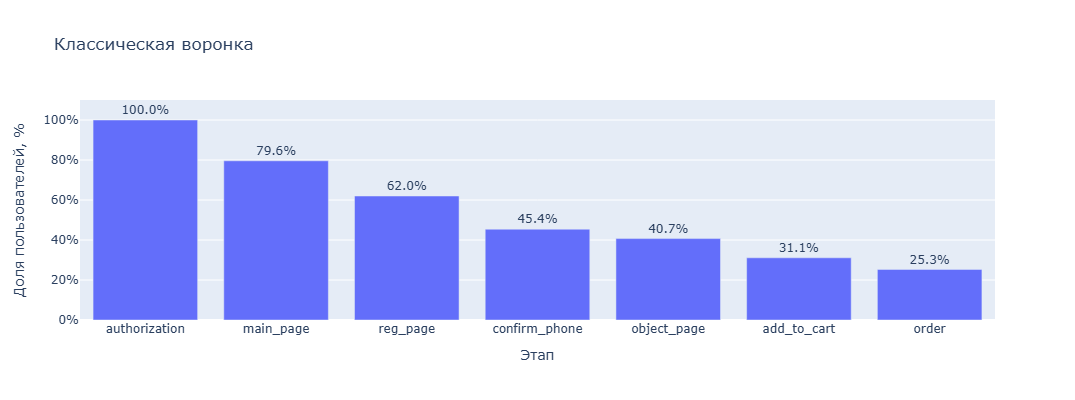

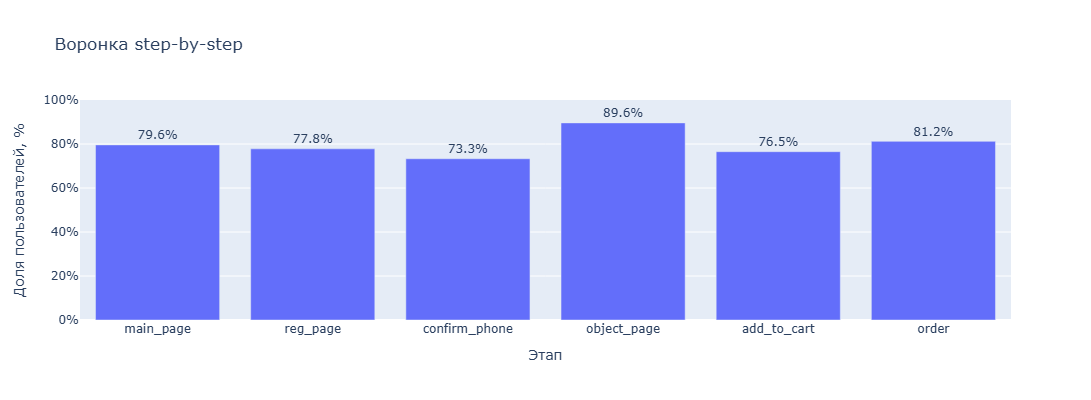

In [19]:
# Визуализируем классическую и step-by-step воронки
fig1 = px.bar(df_funnel,
             x='step',
             y='classic_funnel',
             text='classic_funnel',
             title='Классическая воронка',
             labels={'classic_funnel': 'Доля пользователей', 'step': 'Этап'})

fig1.update_traces(texttemplate='%{text:.1%}', textposition='outside')
fig1.update_layout(yaxis=dict(tickformat='.0%',range=[0,1.1], title='Доля пользователей, %'))
fig1.update_layout(width=800, height=400)

fig2 = px.bar(df_funnel.iloc[1:],
             x='step',
             y='sbs_funnel',
             text='sbs_funnel',
             title='Воронка step-by-step',
             labels={'sbs_funnel': 'Доля пользователей', 'step': 'Этап'})

fig2.update_traces(texttemplate='%{text:.1%}', textposition='outside')
fig2.update_layout(yaxis=dict(tickformat='.0%', range=[0,1], title='Доля пользователей, %'))
fig2.update_layout(width=800, height=400)

fig1.show()
fig2.show()

Анализ общей воронки пользовательского пути:
- Начальный шаг авторизации прошли 7 410 пользователей, но только 25,3% из них дошли до оформления заказа.
- Наибольший отток происходит на этапах регистрации и подтверждения телефона — здесь теряется ~27% всех пользователей (конверсия step-by-step 77,3%).
- Наиболее эффективный этап конверсии - просмотр страницы блюда с конверсией step-by-step 90,6%.

**Вывод:** основные проблемы удержания сосредоточены в начальной фазе взаимодействия с сервисом.

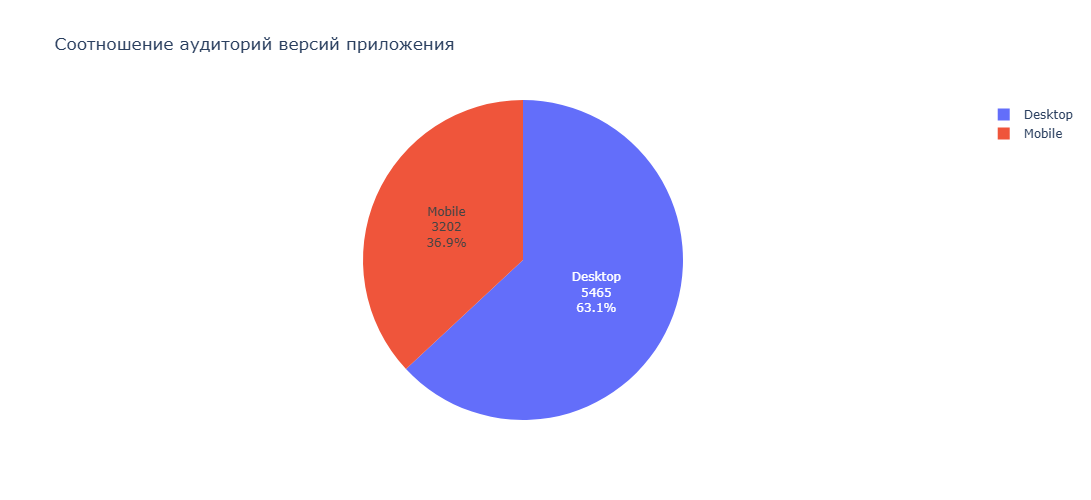

In [20]:
# Оценим соотношение аудиторий десктопной и мобильной версий приложения
df_device = df.groupby('device_type')['user_id'].nunique().reset_index().rename(columns={'user_id': 'cnt_users'})

fig = px.pie(df_device, 
             values='cnt_users', 
             names='device_type',
             title='Соотношение аудиторий версий приложения',
             hover_data=['cnt_users'])

fig.update_traces(textinfo='percent+label+value')

fig.update_layout(font_size=12)
fig.update_layout(width=500, height=500)

fig.show()

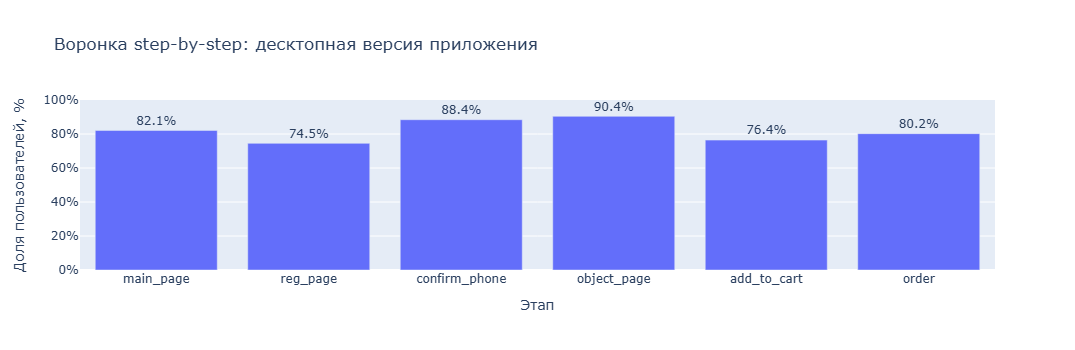

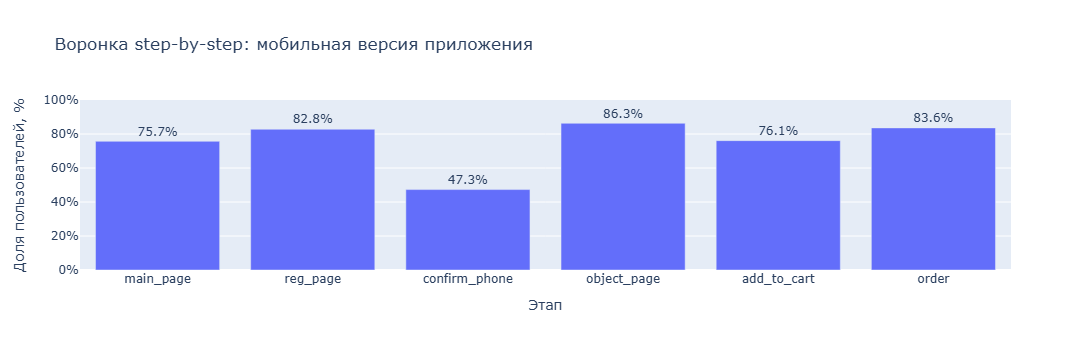

In [21]:
# Строим воронки step-by-step для мобильной и декстопной версий
df_funnel_desktop = (df_filtered[df_filtered['device_type'] == 'Desktop']
                     .groupby('step', as_index=False)['user_id']
                     .nunique()
                     .rename(columns={'user_id': 'cnt_users'}))

df_funnel_desktop['sbs_funnel'] = (df_funnel_desktop['cnt_users'] / df_funnel_desktop['cnt_users'].shift(1)).round(3)

df_funnel_mobile = (df_filtered[df_filtered['device_type'] == 'Mobile']
                     .groupby('step', as_index=False)['user_id']
                     .nunique()
                     .rename(columns={'user_id': 'cnt_users'}))

df_funnel_mobile['sbs_funnel'] = (df_funnel_mobile['cnt_users'] / df_funnel_mobile['cnt_users'].shift(1)).round(3)

# Визуализируем step-by-step воронки
fig1 = px.bar(df_funnel_desktop.iloc[1:],
             x='step',
             y='sbs_funnel',
             text='sbs_funnel',
             title='Воронка step-by-step: десктопная версия приложения',
             labels={'classic_funnel': 'Доля пользователей', 'step': 'Этап'})

fig1.update_traces(texttemplate='%{text:.1%}', textposition='outside')
fig1.update_layout(yaxis=dict(tickformat='.0%', range=[0,1], title='Доля пользователей, %'))
fig1.update_layout(width=800, height=350)

fig2 = px.bar(df_funnel_mobile.iloc[1:],
             x='step',
             y='sbs_funnel',
             text='sbs_funnel',
             title='Воронка step-by-step: мобильная версия приложения',
             labels={'sbs_funnel': 'Доля пользователей', 'step': 'Этап'})

fig2.update_traces(texttemplate='%{text:.1%}', textposition='outside')
fig2.update_layout(yaxis=dict(tickformat='.0%', range=[0,1], title='Доля пользователей, %'))
fig2.update_layout(width=800, height=350)

fig1.show()
fig2.show()

**Вывод**

Анализ воронок по устройствам выявил критическую проблему в мобильной версии приложения. На этапе подтверждения телефона конверсия ste-by-step падает до 47,3% (мобильные) против 88,4% у десктопных пользователей. При этом мобильная аудитория составляет всего 36,1% от общего числа пользователей, поэтому в общей воронке эта проблема маскируется высокими показателями десктопной версии (общая конверсия на этом шаге — 73,3%).

Это подтверждает, что недавние обновления мобильного приложения, затрагивавшие процесс подтверждения телефона, создали существенный барьер для пользователей и являются основной причиной снижения общего количества заказов, несмотря на стабильный приток новых установок.

---
<a id="rfm"></a>
## RFM-сегментация: анализ лояльности клиентов

### Введение

#### Бизнес-контекст
Метрики удержания показывают, что продукт теряет аудиторию сразу после первого заказа:
- **Day 1 retention** — всего 14% (пользователи возвращаются на следующий день)
- **Day 7 retention** — 4–5% (практически полный отток через неделю)

Маркетинг планирует запустить серию рекламных кампаний, направленных на удержание платящих пользователей и реактивацию «уснувших» клиентов.  
Однако универсальные коммуникации неэффективны — разные группы пользователей требуют разных подходов.

#### Цель RFM-анализа
Сегментировать пользователей, совершивших хотя бы один заказ, по трем параметрам:
- **Recency (R)** — как давно был последний заказ
- **Frequency (F)** — как часто пользователь заказывает
- **Monetary (M)** — сколько денег принес за период

Дата отсечки для расчетов — **3 июля 2021 года**.

#### Задачи
1. Рассчитать для каждого пользователя метрики R, F, M.
2. Построить распределения и выбрать границы сегментов.
3. Выделить RFM-сегменты и описать их поведенческие паттерны.
4. Сформулировать рекомендации по маркетинговым стратегиям для каждого сегмента.

### Расчет RFM-метрик и анализ распределений

#### Подготовка данных для RFM
Для сегментации нам потребуются только пользователи, совершившие хотя бы один заказ — именно они являются платящей аудиторией, с которой работает маркетинг.

**Дата отсечки:** 3 июля 2021 года (следующий день после последней даты в данных).  
Это позволяет корректно рассчитать давность последнего заказа: чем меньше дней прошло, тем выше вовлеченность.

**Метрики для каждого пользователя**
| Метрика | Расчет | Бизнес-смысл |
|---------|--------|--------------|
| **Recency (R)** | 2021-07-03 минус дата последнего заказа (дней) | Чем меньше, тем «теплее» клиент |
| **Frequency (F)** | Количество уникальных заказов | Прямое измерение лояльности |
| **Monetary (M)** | Сумма выручки со всех заказов | Ценность клиента для бизнеса |

**Визуализация распределений**

Построим гистограммы для каждой метрики с целью:
- увидеть общую структуру платящей аудитории
- обнаружить аномалии и выбросы
- обоснованно выбрать границы для сегментов

In [22]:
# Создаем датафрейм с информацией для RFM-анализа
df_orders = df[df['event'] == 'order'].copy()
df_orders['days_since_first_order'] = (pd.to_datetime('2021-07-03') - df_orders['datetime']).dt.days

df_rfm = (df_orders
          .groupby('user_id', as_index=False)
          .agg({'days_since_first_order': 'min','event': 'count', 'revenue': 'sum'})
          .rename(columns={'days_since_first_order': 'recency', 'event': 'frequency', 'revenue': 'monetary'}))
display(df_rfm.head())

,user_id,recency,frequency,monetary
0,5506,32,2,3752.00
1,6291,57,1,1750.00
2,6820,41,1,1260.14
3,11062,57,1,3785.60
4,13254,54,1,553.00


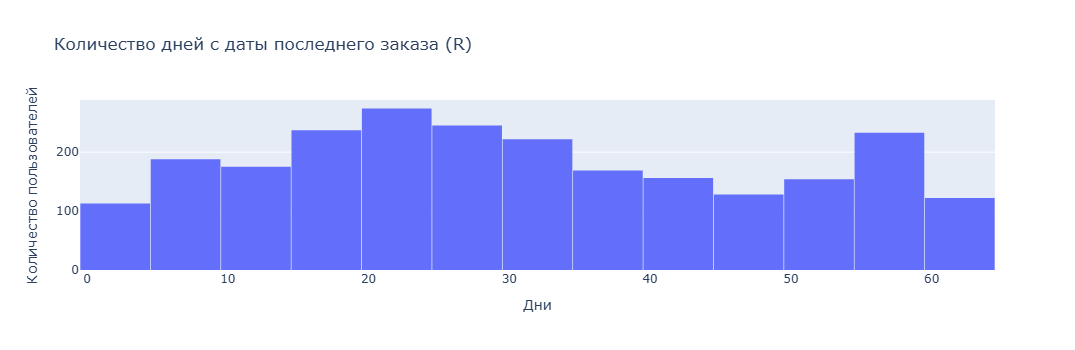

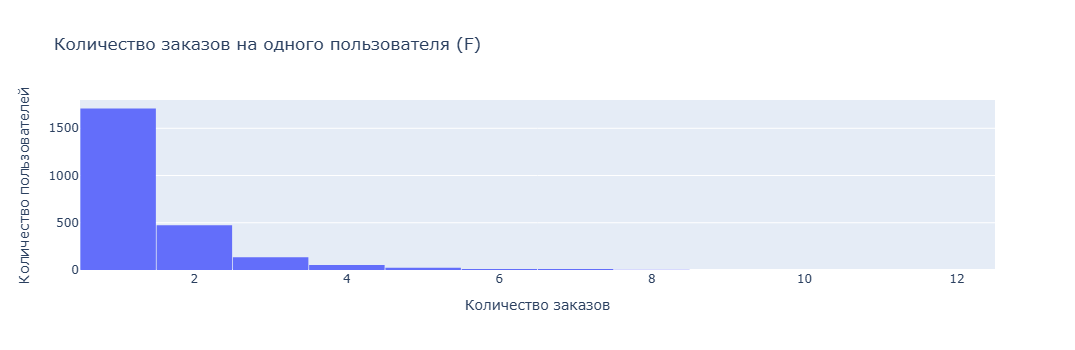

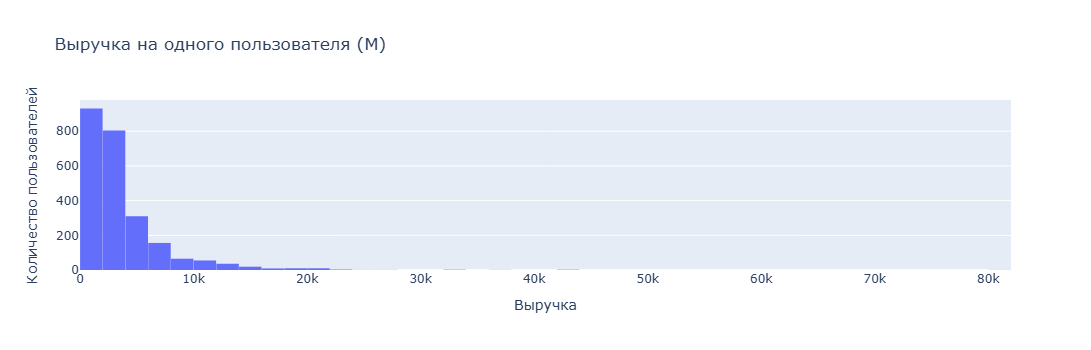

In [23]:
# Строим гистограммы распределения пользователей для параметров RFM
fig1 = px.histogram(df_rfm, 
                   x='recency',
                   nbins=15,
                   title='Количество дней с даты последнего заказа (R)',
                   labels={'recency': 'Дней с последнего заказа'})

fig1.update_layout(
    xaxis_title='Дни',
    yaxis_title='Количество пользователей',
    bargap=0.01,
    width=700,
    height=350)


fig2 = px.histogram(df_rfm, 
                   x='frequency',
                   nbins=15,
                   title='Количество заказов на одного пользователя (F)',
                   labels={'frequency': 'Количество заказов'})

fig2.update_layout(
    xaxis_title='Количество заказов',
    yaxis_title='Количество пользователей',
    bargap=0.01,
    width=700,
    height=350)


fig3 = px.histogram(df_rfm, 
                   x='monetary',
                   nbins=50,
                   title='Выручка на одного пользователя (M)',
                   labels={'monetary': 'Выручка на одного пользователя'})

fig3.update_layout(
    xaxis_title='Выручка',
    yaxis_title='Количество пользователей',
    bargap=0.01,
    width=700,
    height=350)

fig1.show()
fig2.show()
fig3.show()

#### Анализ распределений

**Recency (дней с последнего заказа)**
- Пик распределения приходится на интервал 15–30 дней
- Вторичный всплеск в районе 55–59 дней совпадает с праздничными датами (День Победы) — вероятно, разовая активация пользователей под конкретное событие
- Это важно учитывать при интерпретации «давности»: часть пользователей с R=3 (недавние) — это не лояльные постоянные клиенты, а новые, у которых еще не было возможности проявить лояльность

**Frequency (количество заказов)**
- Распределение близко к экспоненциальному: с каждым дополнительным заказом количество пользователей сокращается в ~3,5 раза
- **70% платящей аудитории** (1709 из 2416) совершили только один заказ — ключевая проблема продукта
- Пользователи с 3+ заказами — всего ~8% базы

**Monetary (суммарные траты)**
- Основная масса пользователей (до 75%) потратила менее 4000 руб. за весь период
- Наблюдается «тяжелый хвост» распределения: небольшая группа клиентов с тратами 30 000 – 80 000 руб. (вероятно, корпоративные заказы или крайне платежеспособные пользователи)
- При сегментации важно отделить этих «китов» от массовой аудитории

### RFM-сегментирование пользователей
#### Методика выделения групп
Для разделения пользователей на однородные поведенческие сегменты используем следующий подход:

| Метрика | Способ разделения | Бизнес-смысл |
|---------|-------------------|--------------|
| **Recency (R)** | 3 равные группы по количеству дней с последнего заказа | Чем выше балл R — тем «теплее» клиент |
| **Frequency (F)** | 1 заказ, 2 заказа, 3+ заказа | Прямое отражение лояльности и привычки |
| **Monetary (M)** | Перцентили 33% и 66% от суммы трат | Разделение на низкий, средний и высокий чек с учетом наличия "китов"|

**Детали расчетов**

- **Recency**: разбивка на равные интервалы позволяет сохранить простоту интерпретации (в отличие от перцентилей, которые могут дать несбалансированные группы при скошенном распределении)
- **Frequency**: выбраны натуральные границы, так как распределение заказов дискретно и сильно скошено — большинство пользователей совершают 1–2 заказа
- **Monetary**: квантильное разделение гарантирует примерно равную наполненность групп деньгами, что важно для маркетинговых расчетов

**Кодировка сегментов**


Каждому пользователю присваивается трехзначный код **RFM**, где:
- R = 1, 2, 3 (3 — самые «свежие»)
- F = 1, 2, 3 (3 — самые частые)
- M = 1, 2, 3 (3 — самые ценные)

Например, сегмент **333** — «золотые» клиенты: недавно, часто, много.

In [24]:
# Сегментируем всех пользователей
df_rfm['r'] = pd.cut(df_rfm['recency'], bins=3, labels=['3', '2', '1'])
df_rfm['f'] = pd.cut(df_rfm['frequency'], bins=[0, 1, 2, 3], labels=['1', '2', '3'])
df_rfm['m'] = pd.qcut(df_rfm['monetary'], q=3, labels=['1', '2', '3'])
print(f"Monetary: 33-й перцентиль - {df_rfm['monetary'].quantile(0.33):.0f} руб., 66-й перцентиль - {df_rfm['monetary'].quantile(0.66):.0f} руб.\n")

df_rfm['rfm'] = df_rfm['r'].astype('str') + df_rfm['f'].astype('str') + df_rfm['m'].astype('str')

display(df_rfm.head())

Monetary: 33-й перцентиль - 1764 руб., 66-й перцентиль - 3584 руб.



,user_id,recency,frequency,monetary,r,f,m,rfm
0,5506,32,2,3752.00,2,2,3,223
1,6291,57,1,1750.00,1,1,1,111
2,6820,41,1,1260.14,2,1,1,211
3,11062,57,1,3785.60,1,1,3,113
4,13254,54,1,553.00,1,1,1,111


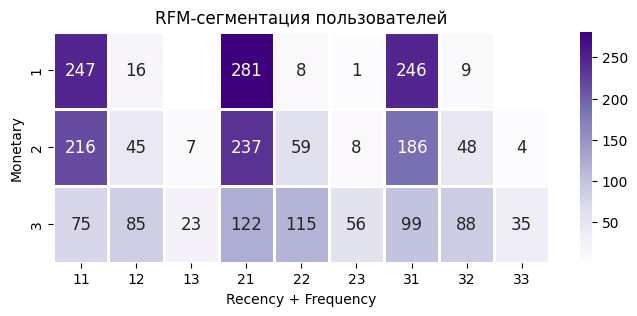

In [25]:
# Строим тепловую карту
df_rfm['rf'] = df_rfm['r'].astype('str') + df_rfm['f'].astype('str')

pivot_rfm = df_rfm.pivot_table(index='m', columns='rf', values='user_id', aggfunc='nunique')

plt.figure(figsize=(8, 3))

sns.heatmap(pivot_rfm,
          cmap='Purples',
          annot=True,
          fmt='.0f',
          linewidths=2,
          annot_kws={"size": 12})

plt.title(f'RFM-сегментация пользователей')
plt.xlabel('Recency + Frequency')
plt.ylabel('Monetary')
plt.show()

#### Расшифровка баллов RFM-сегментации

| Балл | Recency (дней с последнего заказа) | Frequency (количество заказов) | Monetary (сумма трат, руб.) |
|:----:|-----------------------------------|-------------------------------|----------------------------|
| **3** | 0–20 дней | 3 и более заказов | более 3 584 |
| **2** | 21–41 день | 2 заказа | 1 765 – 3 583 |
| **1** | 42+ дня | 1 заказ | менее 1 764 |

#### Интерпретация RFM-сегментов

1. «Новые платежеспособные» (R3, F1-2, M2-3)
    - **Кто это**: недавно зарегистрировались, сделали 1–2 заказа с чеком выше среднего
    - **Доля в базе**: ~18%
    - **Риск**: высокая вероятность оттока после первого положительного опыта
    - **Стратегия**: «закрепить» через welcome-коммуникации, предложить скидку на следующий заказ


2. «Ушедшие ценные» (R1, F2+, M2-3)
    - **Кто это**: не заказывали более 42 дней, но ранее были активны и приносили высокий доход
    - **Доля в базе**: ~12%
    - **Риск**: бездействие маркетинга = потерянные LTV
    - **Стратегия**: реактивация через email/push с персональными предложениями

3. «Одноразовые массовые» (R1-2, F1, M1)
    - **Кто это**: один недорогой заказ и больше не вернулись
    - **Доля в базе**: ~45% (крупнейший сегмент)
    - **Риск**: неэффективное использование маркетингового бюджета
    - **Стратегия**: тестировать разные механики вовлечения (напомнить о себе через 2 недели, предложить блюдо со скидкой)


4. «Стабильные средние» (R2-3, F2, M2)
    - **Кто это**: регулярно заказывают (2+ раза), но с невысоким чеком
    - **Доля в базе**: ~15%
    - **Потенциал**: можно растить вверх по частоте и чеку
    - **Стратегия**: программа лояльности, рекомендации блюд «как в прошлый раз»


5. «Премиум-ядро» (R3, F3, M3)
    - **Кто это**: идеальные клиенты — недавно, часто, много
    - **Доля в базе**: ~5%
    - **Потенциал**: регулярно приносят высокий доход
    - **Стратегия**: эксклюзивные предложения при крупных заказах, ранний доступ к новым ресторанам и специальные условия в программе лояльности

>**Ключевое ограничение интерпретации**
>
>В условиях короткого окна наблюдения (62 дня) и равномерного распределения времени жизни, метрика Recency смешивает принципиально разные когорты пользователей. Это не отменяет, однако, основного вывода: сервис эффективно привлекает первых покупателей, но проваливает их трансформацию в повторных клиентов.

---
<a id="restorany"></a>
## Кластеризация ресторанов: сегментация партнеров

### Введение

#### Бизнес-контекст
Сервис работает с ресторанами на разных условиях: комиссия, маркетинговая поддержка, позиционирование в каталоге.  
В данный момент все партнеры получают примерно одинаковый набор услуг, но их бизнес-модели и показатели могут существенно различаться.

#### Цель кластеризации
Выявить и описать группы ресторанов со схожими характеристиками, чтобы:
- понять структуру партнерской базы
- разрабатывать более релевантные предложения для каждой группы
- персонализировать коммуникацию и условия сотрудничества

#### Параметры для кластеризации
Для каждого ресторана рассчитаем три ключевые метрики:

| Параметр | Что показывает | Бизнес-смысл |
|----------|----------------|-------------|
| **Количество заказов** | Популярность и стабильность спроса | Выделить лидеров, средний сегмент и аутсайдеров |
| **Средний чек (AOV)** | Ценовое позиционирование | Понять, с какой аудиторией работает ресторан |
| **Уникальных блюд в заказах** | Реальный ассортимент, который выбирают | Оценить широту меню и специализацию |

#### Метод анализа
Используем алгоритм **K-Means** для сегментации ресторанов по трем указанным признакам.

#### Этапы работы
1. Подготовка данных и нормализация признаков
2. Выбор оптимального количества кластеров (метод локтя)
3. Кластеризация и интерпретация результатов
4. Описание полученных групп ресторанов

### Подготовка признаков для кластеризации

#### Формирование датасета ресторанов
Для кластеризации нам потребуется агрегировать данные по каждому ресторану-партнеру за весь анализируемый период.

**Источник данных:** только события с типом `order` — именно они содержат информацию о реальных заказах и выручке.

#### Рассчитываемые метрики

| Признак | Расчет | Что отражает |
|---------|--------|--------------|
| **Количество заказов** | Уникальных `order_id` по каждому `rest_id` | Объем спроса, популярность ресторана |
| **Средний чек (AOV)** | Среднее `revenue` по всем заказам ресторана | Ценовой сегмент, позиционирование |
| **Уникальных блюд** | Количество уникальных `object_id` в заказах | Реально востребованный ассортимент |

#### Первичный анализ признаков
После расчета оценим распределения полученных метрик с целью:
- обнаружить рестораны-выбросы (например, с аномально высоким числом заказов)
- понять, нужна ли нормализация данных перед кластеризацией
- сформировать первое представление о структуре партнерской базы

In [26]:
# Создаем датафрейм для сегментации ресторанов
df_rests = (df_orders
            .groupby('rest_id', as_index=False)
            .agg({'order_id': 'nunique','revenue': 'mean', 'object_id': 'nunique'})
            .rename(columns={'order_id': 'cnt_orders', 'revenue': 'aov', 'object_id': 'cnt_dishes'}))

display(df_rests.head())

print(f"Количество ресторанов для кластеризации: {df_rests['rest_id'].nunique()}")

display(df_rests[['cnt_orders', 'aov', 'cnt_dishes']].describe(
    percentiles=[0.05, 0.25, 0.5, 0.75, 0.9, 0.95]).round(2))

,rest_id,cnt_orders,aov,cnt_dishes
0,1be5a933aab34fbab594bebba48e976e,144,2260.180222,28
1,1d6bb74687104fa1953924c9684fe624,108,2959.256481,19
2,2c6095730b514c189ee41c65f03febc3,8,1673.000000,4
3,3247a3b5f9494812a3c1a73c5b61f004,33,2777.209697,4
4,39b7eab4f4704ed2886fafe171489960,33,2011.269697,5


Количество ресторанов для кластеризации: 21


,cnt_orders,aov,cnt_dishes
count,21.00,21.00,21.00
mean,169.00,2557.60,15.29
std,315.84,900.37,23.70
min,5.00,1507.74,1.00
5%,7.00,1565.67,2.00
25%,23.00,1874.55,4.00
50%,77.00,2369.04,6.00
75%,135.00,2959.26,13.00
90%,184.00,3565.39,28.00
95%,1001.00,4561.14,75.00


**Предварительные наблюдения**

- Количество заказов (`cnt_orders`): экстремальная поляризация - единичные рестораны-лидеры с тысячами заказов резко искажают среднее значение, в то время как большинство ресторанов получают менее 200 заказов.

- Средний чек (`aov`): относительно равномерное распределение со средним значением около 2500 рублей, что позволяет выделить как бюджетные (∼1500 руб.), так и премиальные (∼4500 руб.) сегменты ресторанов.

- Ассортимент (`cnt_dishes`): четкое разделение на узкоспециализированные рестораны с минимальным меню и крупные заведения с обширной картой до 90+ блюд, при этом медианный ассортимент составляет всего 6 позиций.


**Вывод:** рестораны действительно сильно различаются по всем трем параметрам.  
Это подтверждает необходимость кластеризации — усредненный портрет «типичного партнера» не отражает реальной структуры базы.

### Выбор оптимального количества кластеров

#### Нормализация признаков
Алгоритм K-Means чувствителен к масштабу данных — признаки с большими значениями (например, количество заказов) будут доминировать над признаками с малыми (средний чек).  
Чтобы этого избежать, приведем все метрики к сопоставимому масштабу с помощью **StandardScaler** (нормализация к среднему = 0, стандартному отклонению = 1).

#### Метод локтя (Elbow Method)
Для определения оптимального числа кластеров используем метрику **инерции** — сумму квадратов расстояний от точек до центроидов своих кластеров.  
Логика метода: при увеличении K инерция снижается, но после некоторой точки падение замедляется — образуется «излом», который и указывает на оптимальное количество кластеров.

**Диапазон оценки:** от 1 до 7 кластеров (при 21 ресторане больше 7 кластеров теряют смысл).

In [27]:
# Создаем датафрейм с признаками ресторанов
data = df_rests.drop('rest_id', axis=1).copy()

# Нормализуем данные
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

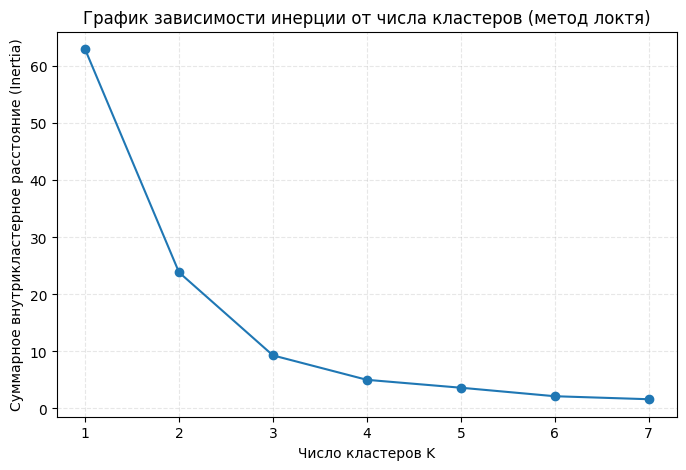

In [28]:
# Определяем оптимальное количество кластеров с помощью правила локтя
inertias = []

min_k = 1
max_k = 7

plt.figure(figsize=(8, 5))
 
for k in range(min_k, max_k + 1):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)  
    km.fit(data_scaled)  # Обучаем на масштабированных данных
    inertias.append(km.inertia_)

plt.plot(range(min_k, max_k + 1), inertias, marker='o')
plt.xlabel('Число кластеров K')
plt.ylabel('Суммарное внутрикластерное расстояние (Inertia)')
plt.title('График зависимости инерции от числа кластеров (метод локтя)')
plt.grid(alpha=0.3, linestyle='--')
plt.show()

#### Интерпретация графика

На графике метода локтя наблюдается плавное снижение инерции без ярко выраженного излома. Это типичная ситуация для небольших выборок — четкий «локоть» формируется редко.

**Возможные варианты K:**

| K | Аргументы за | Аргументы против |
|---|--------------|------------------|
| **3** | Формальный излом на графике | Может быть слишком грубой сегментацией |
| **4** | Хорошо интерпретируется бизнес-логикой (лидеры, премиум, массмаркет, аутсайдеры) | Небольшие кластеры (2–6 ресторанов) |
| **5** | Более тонкая сегментация | Риск переобучения и дробления выбросов |

#### Итоговый выбор
Останавливаемся на **K = 4** — это значение:
- позволяет выделить содержательно различные группы ресторанов
- дает достаточно наполненные кластеры для анализа
- согласуется с бизнес-гипотезой о 3–4 типах партнеров

> **Важное замечание**
>
> При малом количестве объектов (всего 21 ресторан) любые результаты кластеризации следует интерпретировать с осторожностью.  
> Кластеры могут отражать не устойчивые паттерны, а случайные группировки выбросов.  
> Для подтверждения устойчивости результатов желательно повторить анализ на более длинном периоде или с дополнительными признаками.

### Кластеризация ресторанов и интерпретация результатов

Для понимания структуры кластеров построим два графика:
- Средний чек vs Количество заказов — покажет связь между популярностью и ценовым сегментом
- Ассортимент vs Количество заказов — выявит зависимость между широтой меню и спросом

На графики нанесем как сами рестораны (точки), так и центроиды кластеров (кресты) — это поможет увидеть, вокруг каких значений сгруппированы объекты.

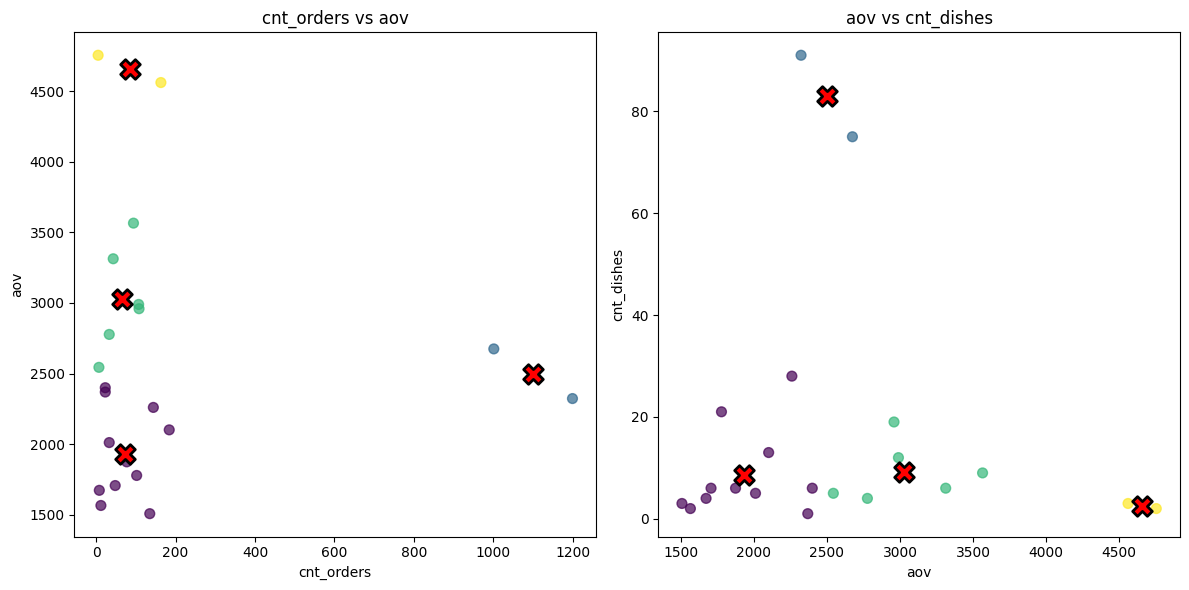

In [29]:
# Проводим кластеризацию
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
labels = kmeans.fit_predict(data_scaled)

# Преобразуем центроиды обратно в исходный масштаб
centroids_original = scaler.inverse_transform(kmeans.cluster_centers_)

# Добавляем метки кластеров в исходные данные
data_with_clusters = data.copy()
data_with_clusters['cluster'] = labels

# Визуализируем кластеры
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axs = ['cnt_orders', 'aov', 'cnt_dishes']

for i, (x_idx, y_idx) in enumerate([[0, 1], [1, 2]]):
    x_label, y_label = axs[x_idx], axs[y_idx]
    
    # Точки из исходных данных
    axes[i].scatter(
        data_with_clusters[x_label],  
        data_with_clusters[y_label],  
        c=data_with_clusters['cluster'],
        cmap='viridis',
        s=50,
        alpha=0.7
    )
    
    # Центроиды в исходном масштабе
    axes[i].scatter(
        centroids_original[:, x_idx],
        centroids_original[:, y_idx],
        s=200,
        c='red',
        edgecolors='black',
        linewidths=2,
        marker='X'
    )
    
    axes[i].set_xlabel(x_label)
    axes[i].set_ylabel(y_label)
    axes[i].set_title(f'{x_label} vs {y_label}')

plt.tight_layout()
plt.show()

In [30]:
# Выводим подробную информацию о кластерах
df_rests['cluster'] = labels

cluster_stats = df_rests.groupby('cluster').agg({
    'rest_id': 'count',
    'cnt_orders': ['median', 'mean', 'std', 'min', 'max'],
    'aov': ['median', 'mean', 'std', 'min', 'max'],
    'cnt_dishes': ['median', 'mean', 'std', 'min', 'max'],
    }).T.round(2)

display(cluster_stats)

cluster                  0        1        2        3
rest_id    count     11.00     2.00     6.00     2.00
cnt_orders median    48.00  1100.00    68.50    84.00
           mean      71.73  1100.00    65.33    84.00
           std       61.01   140.01    43.19   111.72
           min        8.00  1001.00     7.00     5.00
           max      184.00  1199.00   108.00   163.00
aov        median  1874.55  2498.83  2974.42  4657.77
           mean    1931.62  2498.83  3024.75  4657.77
           std      318.03   248.65   366.97   136.66
           min     1507.74  2323.01  2544.00  4561.14
           max     2399.84  2674.65  3565.39  4754.40
cnt_dishes median     6.00    83.00     7.50     2.50
           mean       8.64    83.00     9.17     2.50
           std        8.58    11.31     5.64     0.71
           min        1.00    75.00     4.00     2.00
           max       28.00    91.00    19.00     3.00

#### Характеристика выделенных групп

Проведенная кластеризация позволила разделить 21 ресторан на 4 группы, различающиеся по трем анализируемым показателям. 
Важно учитывать, что при малом объеме выборки границы между группами могут быть неустойчивыми, а отдельные рестораны — влиять на центроиды сильнее, чем в масштабной выборке.

**Группа 0 (11 ресторанов) — «Массовый сегмент»**
- Объединяет половину всех ресторанов-партнеров
- Характеризуется невысоким средним чеком (~1 900 руб.) и умеренным спросом (8–184 заказа)
- Заказываемый ассортимент — от 1 до 28 блюд, что может отражать как реальную широту меню, так и покупательские предпочтения

**Группа 1 (2 ресторана) — «Лидеры по заказам»**
- Резко выделяются объемом заказов (1000+ против менее 200 у остальных)
- Средний чек — около 2 500 руб. (близок к общерыночному)
- Заказываемый ассортимент — 75–90+ позиций, что может указывать на широкое меню либо на высокую популярность, при которой клиенты пробуют разные блюда

**Группа 2 (6 ресторанов) — «Сбалансированные»**
- Демонстрируют устойчивый спрос и средний чек выше среднего (~3 000 руб.)
- Заказываемый ассортимент шире, чем в массовом сегменте (4–19 позиций)
- Потенциально — наиболее перспективная группа для развития и тестирования новых механик

**Группа 3 (2 ресторана) — «Высокий чек»**
- Рестораны с максимальным средним чеком (~4 650 руб.)
- При этом спрос на них нестабилен (от 5 до 163 заказов), а в заказах фигурирует всего 2–3 уникальных блюда
- Возможные интерпретации: узкая специализация (например, стейк-хаус) либо особенности меню, где клиенты заказывают только топ-позиции


> **Ограничения анализа**
>
>1. **Размер выборки** — всего 21 ресторан, поэтому выделенные группы скорее описывают конкретных партнеров в данном периоде, чем формируют устойчивую типологию
>
>2. **Ассортимент** — в оценку попали только те блюда, которые реально заказывали, а не все меню ресторана. Ресторан с широкой картой может попасть в группу с «узким» ассортиментом, если клиенты выбирают лишь несколько позиций
>
>3. **Связь цены и спроса** — наблюдаемые паттерны (например, низкий спрос у дорогих ресторанов) могут быть следствием короткого периода наблюдения, а не устойчивой закономерности
>
>4. **Ценность результата** — даже с учетом ограничений, кластеризация помогает увидеть, что партнеры неоднородны, и сформировать первые гипотезы для дифференцированного подхода.

---
<a id="vyvody"></a>
## Итоговые выводы и рекомендации

### Резюме исследования
В рамках анализа были рассмотрены три ключевых аспекта, влияющих на рост продукта:
- **пользовательский путь** и конверсия в заказ
- **лояльность клиентов** (RFM-сегментация)
- **структура партнерской базы** (кластеризация ресторанов)

Каждое направление дало практические инсайты, которые могут быть использованы продуктовой и маркетинговой командами.

###  Пользовательский путь: критический сбой в мобильном приложении

#### Ключевые факты
| Метрика | Значение |
|---------|----------|
| Общая конверсия в заказ | 32,6% |
| Отток на этапе регистрации и подтверждения телефона | 27% от всех новых пользователей |
| Конверсия confirm_phone (Mobile) | 55,1% |
| Конверсия confirm_phone (Desktop) | 90,2% |

#### Вывод
Основная потеря пользователей происходит именно в мобильной версии на этапе подтверждения телефона.  
В общей воронке эта проблема маскируется высокими показателями десктопа, но именно мобильный трафик — главный источник оттока.

#### Рекомендация
Провести аудит и редизайн процесса подтверждения телефона в мобильном приложении.  
Рассмотреть альтернативные механики: автоматическое определение номера, подтверждение через мессенджеры, упрощённую регистрацию через соцсети.  
Исправление этого шага даст максимальный прирост конверсии.

### RFM-сегментация:  70% клиентов уходят после первого заказа

#### Распределение клиентов по сегментам

| Сегмент | Доля | Характеристика | Стратегия |
|---------|------|----------------|-----------|
| **Новые платежеспособные** | 15–20% | Недавние, 1–2 заказа, чек выше среднего | Закрепить привычку: welcome-коммуникации, скидка на следующий заказ |
| **Ценные ушедшие** | 10–15% | 42+ дней без заказов, ранее были активны и приносили высокий доход | Реактивация: персональные предложения, опрос о причинах ухода |
| **Массовые одноразовые** | 40–50% | 1 недорогой заказ, не вернулись | Вовлечение: напоминания, рекомендации, тестирование механик лояльности |
| **Стабильные регулярные** | 15–20% | 2+ заказа, умеренный чек, активны в последние 21–41 день | Укрепление: программа лояльности, поощрение регулярности |
| **Премиум-ядро** | ~5% | Недавно, часто, много | Эксклюзив: ранний доступ, персональный менеджер, особые условия |

#### Главный вывод
70% платящей аудитории совершают только один заказ.  
Продукт эффективно привлекает новых клиентов, но не удерживает их. Без системной работы с удержанием маркетинговый бюджет работает неэффективно.

#### Рекомендации:
1. Самый массовый сегмент (40–50%) — внедрить механики вовлечения с минимальной стоимостью (напоминания, скидка 10%)
2. Новые платежеспособные (15–20%) — предлагать скидку на второй заказ (быстрая окупаемость)
3. Ценные ушедшие (10–15%) — подготовить персональные предложения (точечные затраты)
4. Регулярные и премиум — внедрить долгосрочные программы лояльности

### Кластеризация ресторанов: 4 бизнес-модели партнеров


| Группа | Кол-во | Характеристика | Рекомендации |
|--------|--------|----------------|--------------|
| **Массовый сегмент** | 11 | Низкий чек (~1 900 ₽), умеренный спрос, базовый ассортимент | Стандартные условия, помощь в повышении чека и оптимизации меню |
| **Премиум-ниша** | 2 | Высокий чек (~4 650 ₽), узкий ассортимент, нестабильный спрос | Эксклюзивные размещения, таргетинг на платежеспособную аудиторию |
| **Сбалансированные** | 6 | Средний чек (~3 000 ₽), устойчивый спрос, разнообразное меню | Поддержка в развитии, тестирование новых механик |
| **Лидеры** | 2 | 1000+ заказов, широкий ассортимент, средний чек | Партнерские программы, совместные акции, приоритетная поддержка |

>**Важное ограничение**
>
>Анализ выполнен на данных о заказах 21 ресторане за 2 месяца.  
>Выделенные группы описывают текущую структуру, но для построения устойчивой типологии требуется большая выборка и более длительный период наблюдения.

### Общие рекомендации для бизнеса

| Направление | Действие | Ожидаемый эффект |
|-------------|----------|------------------|
| **Мобильное приложение** | Исправить подтверждение телефона | Рост конверсии новых пользователей |
| **Удержание клиентов** | Внедрить программу лояльности и триггерные коммуникации | Снижение оттока, рост LTV |
| **Работа с ресторанами** | Персонализировать условия под кластеры | Повышение лояльности партнеров, оптимизация комиссий |

### Заключение

Проведенный анализ позволил:
- обнаружить **критическую точку оттока** в мобильном приложении
- понять **реальную структуру клиентской базы** и выделить приоритетные сегменты для работы
- увидеть **неоднородность ресторанов-партнеров** и сформировать первые гипотезы для дифференцированного подхода

Дальнейшие шаги — внедрение предложенных изменений и мониторинг их эффекта через когортный анализ и A/B-тесты.